# Import libraries

In [1]:
import sklearn
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from eli5 import show_weights, show_prediction
import seaborn as sns
from sklearn.manifold import TSNE
import os
import pandas as pd
from skbio import Protein
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna, generic_protein

#custom
from py.helper import DataProcessing
from py.ml_metrics import evaluate_model, multiclass_logloss
from py.plotting import plot_tsne


/home/aneesh/Projects/covid_bh_ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/aneesh/Projects/covid_bh_ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [2]:
# set K-mer length here
kmer = 4


In [3]:
rvdb14 = DataProcessing('RVDB14_complete_coronavirus_fixed.fasta', 'RVDB14_Coronavirus_meta_data_human_pathogen.csv')

In [4]:
cleaned_path = os.path.join(rvdb14.data_path, 'RVDB14_complete_coronavirus_fixed.fasta.csv')

cleaned_df = pd.read_csv(cleaned_path, dtype={'label':int})
# remove nans
cleaned_df.dropna(inplace=True)

# remove artifacts
for index, row in cleaned_df.iterrows():
    if row['label'] < 0:
        cleaned_df.drop(index, inplace=True)
cleanded_df = cleaned_df[cleaned_df['label'] >= 0]
cleaned_df.head()

,seq,id,description,label,accession
0,ACTTTTAAAGATAAGTGAGTGTAGCGTAGCTGCCTACTTTCTTTAA...,acc|REFSEQ|NC_030292.1|Ferret,acc|REFSEQ|NC_030292.1|Ferret coronavirus isol...,0,NC_030292.1
1,ACTTAAGTGTCTTATCTATCTATAGATAGAAAAGTCGCTTTTTAGA...,acc|REFSEQ|NC_028752.1|Camel,acc|REFSEQ|NC_028752.1|Camel alphacoronavirus ...,1,NC_028752.1
2,AGTAAAGTGAGTGTAGCGTGGCTATATCTCTTCTTTTACTTTAACT...,acc|REFSEQ|NC_028806.1|Swine,acc|REFSEQ|NC_028806.1|Swine enteric coronavir...,1,NC_028806.1
3,AAGTGTCGTGCTCCTAGGGGTTGCACTTGACGTGTTCCGTCACGTA...,"acc|REFSEQ|NC_028824.1|BtRf-AlphaCoV_YN2012,","acc|REFSEQ|NC_028824.1|BtRf-AlphaCoV_YN2012, a...",0,NC_028824.1
4,GGCCCCCATGGCTAGCAACCGTATTTCGTTGGCTTTTGCCAATGAT...,"acc|REFSEQ|NC_028814.1|BtRf-AlphaCoV_HuB2013,","acc|REFSEQ|NC_028814.1|BtRf-AlphaCoV_HuB2013, ...",1,NC_028814.1


# Split the dataframe

In [5]:
#split dataframe
mask = np.random.rand(len(cleaned_df)) < 0.8
train_df = cleaned_df[mask]
test_df = cleaned_df[~mask]
print(f'Size of the test df: {len(test_df)}. Size of the tain df: {len(train_df)}.')

Size of the test df: 434. Size of the tain df: 1772.


In [7]:
#split
xtrain = train_df['seq'].values
xtest = test_df['seq'].values

# Vectorize the sequence

In [8]:
#vectorize
ctv = CountVectorizer(analyzer='char', ngram_range=(kmer, kmer), lowercase=False) # kmer: k-mer length

ctv.fit(list(xtrain)+list(xtest))
xtrain_ctv = ctv.transform(xtrain)
xtest_ctv = ctv.transform(xtest)

In [24]:

class_dict = dict(zip(range(2), [f'cluster_{i}' for i in range(2)]))
ytrain = train_df['label'].values
ytest = test_df['label'].values


/home/aneesh/Projects/covid_bh_ml/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Multiclass log loss: 0.8384747004714392
dict_values(['cluster_0', 'cluster_1'])
Normalized confusion matrix
[[0.68 0.32]
 [0.42 0.58]]


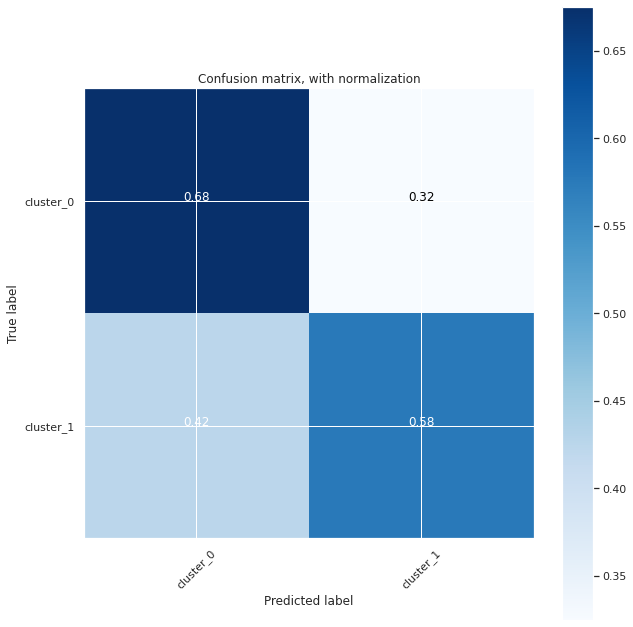

In [25]:
#fit logistic regression on CountVectorizer
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=1.0, max_iter=4000)
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xtest_ctv)
evaluate_model(predictions, ytest, class_dict)

In [26]:
from eli5 import show_weights
# show_weights(clf, target_names=class_dict, vec=ctv)
show_weights(clf, vec=ctv, top=25, feature_filter=lambda x: x != '<BIAS>', target_names=class_dict)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1772 samples in 0.005s...
[t-SNE] Computed neighbors for 1772 samples in 1.446s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1772
[t-SNE] Computed conditional probabilities for sample 1772 / 1772
[t-SNE] Mean sigma: 10.132933
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.918289
[t-SNE] KL divergence after 1000 iterations: 0.299293


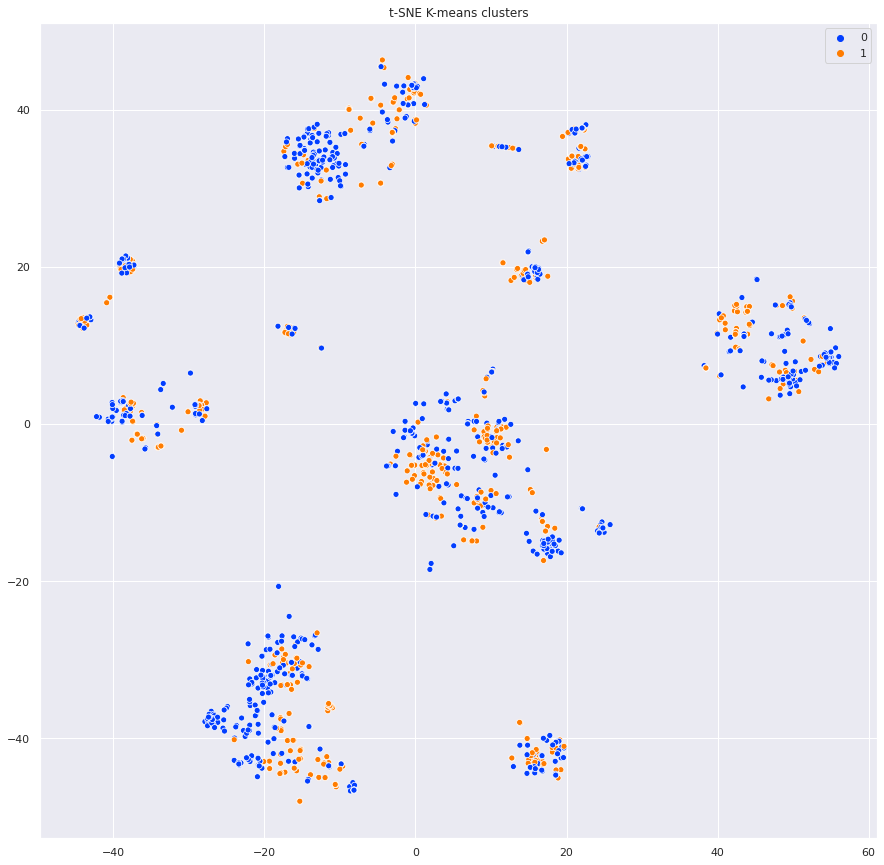

In [27]:
plot_tsne(xtrain_ctv, ytrain, 50)

In [28]:
multiclass_logloss(ytest, predictions)

0.8384747004714392

In [33]:
import xgboost as xgb
# Fitting a simple xgboost on CountVectorizer
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xtest_ctv)


In [34]:
multiclass_logloss(ytest, predictions)

0.6850958337165332

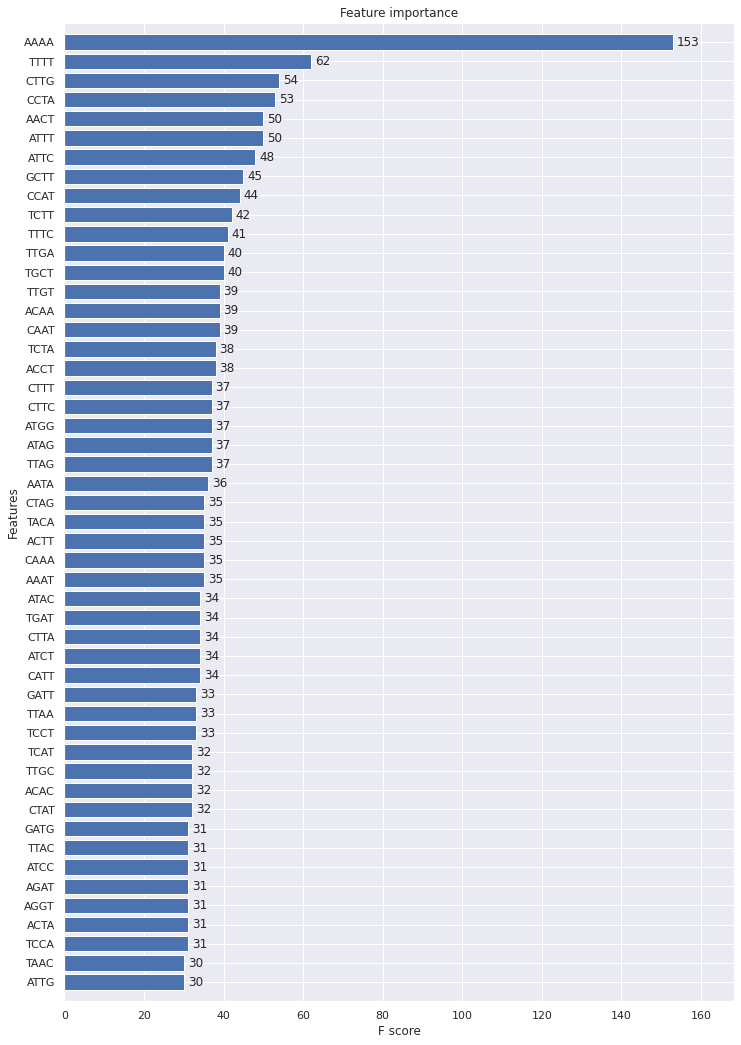

In [39]:
# feature importances
clf.get_booster().feature_names = ctv.get_feature_names()
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(clf.get_booster(), max_num_features=50, height=0.8, ax=ax)
plt.show()